In [1]:
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

import matplotlib.tri as tri
import matplotlib.pyplot as plt

import pandas as pd

from multiprocessing import Pool
from tqdm import tqdm 

PI = math.pi

In [2]:
# The function can calculate the scale length (Xscale, Yscale) 
# of the input concentration distribution (Concnt)

def Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac):
    
    M2d = Concnt*Dx*Dy
    total_mass = np.sum(M2d, axis=(0,1))
    
    Ysum = np.sum(M2d,axis=1) # sum along x axis
    Ysum_sort = sorted(Ysum, reverse=True)
    Ysum_cum = np.cumsum(Ysum_sort)
    numY = abs(Ysum_cum - frac*total_mass).argmin()
    Yscale = numY*Dy
    
    Xsum = np.sum(M2d,axis=0) # sum along x axis
    Xsum_sort = sorted(Xsum, reverse=True)
    Xsum_cum = np.cumsum(Xsum_sort)
    numX = abs(Xsum_cum - frac*total_mass).argmin()
    Xscale = numX*Dx
    
    return Xscale, Yscale

In [3]:
def tilt_C2d(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB):
    
    # find the long and short radius given concentration distribution
    # build a 2D nest for integrationn
    Nb_mid = int(Nb/2)

    # interval in long radius
    Adx = LenA*np.sin(Theta)
    Ady = LenA*np.cos(Theta)

    # interval in short radius
    Bdy = LenB*np.sin(Theta)
    Bdx = LenB*np.cos(Theta)

    # define the location in 2D xy mesh used to determine initial concentration
    Y1d = np.zeros((Na,Nb))
    X1d = np.zeros((Na,Nb))

#     print('Y1d.shape: ', Y1d.shape)

    # find the location of 1D grid in 2D XY grids
    for i in range(Na):
        X1d[i,Nb_mid] = -Adx*Na/2 + Adx*(i+0.5)   # ???
        Y1d[i,Nb_mid] = -Ady*Na/2 + Ady*(i+0.5)   # ???

    for j in range(Nb_mid+1, Nb, 1):
        X1d[:,j] = X1d[:,j-1] - Bdx
        Y1d[:,j] = Y1d[:,j-1] + Bdy
    
    for j in range(Nb_mid-1, -1, -1):
        X1d[:,j] = X1d[:,j+1] + Bdx
        Y1d[:,j] = Y1d[:,j+1] - Bdy

        
    # set the initial concentration for 1D
    C1d = np.zeros((Na,Nb))

    # Find the correct initial theta for 1D:
    F1  = interpolate.interp2d(x, y, Concnt, kind='cubic')

    for i in range(Na):
        for j in range(Nb):
#             if( abs(X1d[i,j])<abs(max(x)) or abs(Y1d[i,j])<abs(max(y)) ): # in case the tilt 2-D out ot range
                C1d[i,j] = F1( X1d[i,j], Y1d[i,j] )
        
    return C1d, X1d, Y1d

In [5]:
# grid resolution
Dx = 200 # [m]
Dy = 20 # [m]

# grid number
Nx = 5000 # 5000 # 243 # 483
Ny = 300  # 135  # 271

# For high resolution 2D Eulerian model
# for the first 24 hours

Ymax =  Dy*Ny/2
Ymin = -Dy*Ny/2
Xmax =  Dx*Nx/2
Xmin = -Dx*Nx/2


i_init = round(Nx/2)
j_init = round(Ny/2)
print('center:',i_init,j_init)

x = []
for i in range(Nx):
    x.append((i-i_init)*Dx)
    
y = []
for j in range(Ny):
    y.append((j-j_init)*Dy)

X, Y = np.meshgrid(x, y)

center: 2500 150


In [6]:
# read concnt_2d from .txt file

Nb   = 2*math.ceil(Ny/4)*4
frac = 0.95
concnt2d = np.zeros((Ny,Nx))

C1d_center = []
C2d_center = []

for it in tqdm(np.arange(1,288,1)):
#     print(it)

    data = pd.read_csv('Lb_'+str(it)+'_10min.txt')
    [Lb,La] = data.values
    
    data = pd.read_csv('Concnt_1d_'+str(it)+'_10min.txt')
    concnt1d = data.values    
    C1d_center.append( concnt1d[int(Nb/2)]*La*Lb )
#     print(np.max(concnt1d[:])*La*Lb, concnt1d[int(Nb/2)]*La*Lb,  concnt1d[int(Nb/2)-1]*La*Lb, concnt1d[int(Nb/2)+1]*La*Lb)
    
    
    data = pd.read_csv('Concnt_2d_'+str(it)+'_10min.txt')
    concnt2d = data.values
    
    Concnt2 = concnt2d
    # calculate ScaleX and ScaleY containing 99%  of total mass
    Xscale2, Yscale2 = Get_XYscale(Concnt2, Dx, Dy, Nx, Ny, frac)

    Height2 = Lb*Nb # Yscale2 # refernce of the plume cross-section vertical scale for 1D initial
    Length2 = Xscale2

    Theta2 = math.atan(Xscale2/Yscale2)

    # 1D grid length

    # LenB doesn't have big influence on final results
    LenB2 = Lb # Dy # number is a arbitraty number
    LenA2 = Dx # Dx*1.5 # Dx
#     print('LenB, LenA: ', LenB2, LenA2)

    Nb2 = int(Height2/LenB2) # short radius
    Nb2 = math.ceil(Nb2/4)*4

    Na2 = Nx # int(Length2/Dx) # Nx # long radius
    Na2 = math.ceil(Na2/4)*4
#     print('Nb, Na: ', Nb2, Na2)

    Nb2_25  = int(Nb2/4)
    Nb2_mid = Nb2_50 = int(Nb2/4*2)
    Nb2_75  = int(Nb2/4*3)

    Na2_25  = int(Na2/4)
    Na2_mid = Na2_50 = int(Na2/4*2)
    Na2_75  = int(Na2/4*3)

    C1d2, X1d2, Y1d2 = tilt_C2d(Concnt2, x, y, Dx, Dy, Nx, Ny, Theta2, Na2, Nb2, LenA2, LenB2)
    
    Lb2 = Lb

    C_box2 = np.zeros(Nb2)
    C_box2_Asum = np.zeros(Nb2)

    for ib in range(Nb2):
        C_box2_Asum[ib] = sum(C1d2[:,ib]) *(LenA2*LenB2)


    C2d_center.append(np.max(C_box2_Asum))
#     print(np.max(C_box2_Asum), C_box2_Asum[int(Nb2/2)], C_box2_Asum[int(Nb2/2)+1], C_box2_Asum[int(Nb2/2)-1])
    

100%|██████████| 287/287 [6:16:00<00:00, 78.61s/it]  


In [7]:
# # Find the correct initial theta for 1D:

# y1d = []

# for j in np.arange(1,Nb+1,1):
#     y1d.append( (j-Nb/2)*10-5 )

# F1       = interpolate.interp1d(y, C1d_center, kind='linear')

# C1d_new = F1()

In [8]:
df1 = pd.DataFrame(C1d_center)
df1.to_csv('C1d_center_time_series_10min.txt', index = False)

df2 = pd.DataFrame(C2d_center)
df2.to_csv('C2d_center_time_series_10min.txt', index = False)

In [9]:
# np.array(C1d_center)

In [67]:
# c1 = []
# c2 = []
# hours1 = []

# for i in np.arange(0,47,1):
#     hours1.append(i+1)
    
#     c1.append( (C1d_center[i][0]+C1d_center[i+1][0])*0.5 ) # C1d_center[i][0] # 
#     c2.append( (C2d_center[i]+C2d_center[i+1])*0.5 ) #  C2d_center[i] #  
# #     Diff.append((c1-c2)/c2)
# #     Diff.append( (C1d_center[i][0] - C2d_center[i-1])/C2d_center[i-1] )
    
# Diff = np.array(Diff)
# # Diff
# c1 = np.array(c1)
# c2 = np.array(c2)

# Diff1 = ( np.array(c1)-np.array(c2) )/ np.array(c2)


# c1.shape, c2.shape, Diff1.shape

((47,), (47,), (47,))

In [68]:
# c11 = []
# c22 = []
# hours2 = []

# for i in np.arange(0,46,1):
#     hours2.append(i+1)
    
#     c11.append( (c1[i]+c1[i+1])*0.5 ) # C1d_center[i][0] # 
#     c22.append( (c2[i]+c2[i+1])*0.5 ) #  C2d_center[i] #
    
# Diff2 = ( np.array(c11)-np.array(c22) )/ np.array(c22)


In [69]:
# Lb, La

(array([1.37306434]), array([81569.37496495]))

Text(0.5, 0, 'Time [hour]')

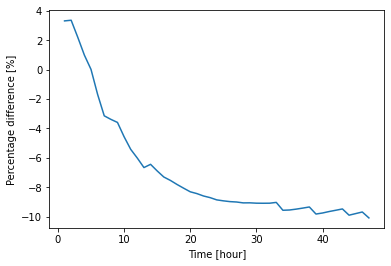

In [71]:
# plt.plot( hours1[:], Diff1[:]*100)
# plt.ylabel('Percentage difference [%]')
# plt.xlabel('Time [hour]')

Text(0.5, 0, 'Time [hour]')

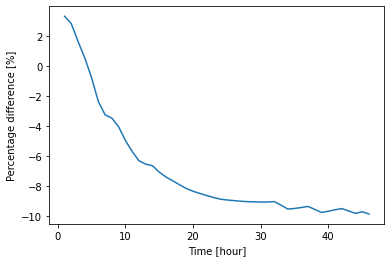

In [72]:
# plt.plot( hours2[:], Diff2[:]*100)
# plt.ylabel('Percentage difference [%]')
# plt.xlabel('Time [hour]')

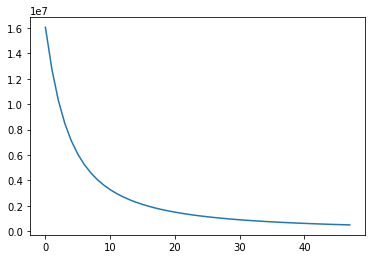

In [11]:
# plt.plot(C1d_center)